# Collaborative Filtering for Destination Recommendations

All the steps bellow based on: https://keras.io/examples/structured_data/collaborative_filtering_movielens/

Note: please do not make any changes or run into this code! If you want to try this code, do make a copy to your drive.

## Installations

In [1]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

2024-06-17 00:27:15.471637: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 00:27:15.552119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 00:27:17.518456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tourism_rating.csv to tourism_rating.csv
Saving tourism_with_id.csv to tourism_with_id.csv


## Cleaning Data

In [2]:
# local
rates = pd.read_csv('./datasets/tourism_rating.csv')
places = pd.read_csv('./datasets/tourism_with_id.csv')

In [ ]:
# google colab
rates = pd.read_csv('/content/tourism_rating.csv')
places = pd.read_csv('/content/tourism_with_id.csv')

In [3]:
rates

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [4]:
print("Jumlah duplikasi: ", rates.duplicated().sum())
rates.describe()

Jumlah duplikasi:  79


,User_Id,Place_Id,Place_Ratings
count,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,3.066500
std,86.137374,126.228335,1.379952
min,1.000000,1.000000,1.000000
25%,77.000000,108.750000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


In [5]:
rates = rates.drop_duplicates()
rates.reset_index(drop=True)

rates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9921 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        9921 non-null   int64
 1   Place_Id       9921 non-null   int64
 2   Place_Ratings  9921 non-null   int64
dtypes: int64(3)
memory usage: 310.0 KB


In [6]:
places

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906,NaN,433
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822,NaN,434
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436


In [7]:
places = places.drop(columns=[
                              'Coordinate',
                              'Unnamed: 11',
                              'Unnamed: 12',
                              'Time_Minutes',
                              'Long',
                              'Lat',
                              'Rating'])
places

,Place_Id,Place_Name,Description,Category,City,Price
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


## Merging

In [8]:
df_merged = rates.merge(places, on='Place_Id')
df_merged

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,Yogyakarta,75000
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari,Semarang,3000
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,Yogyakarta,0
...,...,...,...,...,...,...,...,...
9916,300,425,2,Waterpark Kenjeran Surabaya,Waterpark Kenjeran Surabaya merupakan wisata k...,Taman Hiburan,Surabaya,35000
9917,300,64,4,Museum Sasmita Loka Ahmad Yani,Museum Sasmita Loka Ahmad Yani adalah salah sa...,Budaya,Jakarta,2000
9918,300,311,3,The Lodge Maribaya,The Lodge Maribaya adalah salah satu tempat wi...,Cagar Alam,Bandung,25000
9919,300,279,4,Masjid Agung Trans Studio Bandung,Masjid Agung Trans Studio Bandung (TSB) berdir...,Tempat Ibadah,Bandung,0


In [9]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        9921 non-null   int64 
 1   Place_Id       9921 non-null   int64 
 2   Place_Ratings  9921 non-null   int64 
 3   Place_Name     9921 non-null   object
 4   Description    9921 non-null   object
 5   Category       9921 non-null   object
 6   City           9921 non-null   object
 7   Price          9921 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 620.2+ KB


## Pre-processing

encode users and places as integer indices

In [10]:
user_ids = df_merged["User_Id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

place_ids = df_merged["Place_Id"].unique().tolist()
place2place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded2place = {i: x for i, x in enumerate(place_ids)}

df_merged["user"] = df_merged["User_Id"].map(user2user_encoded)
df_merged["place"] = df_merged["Place_Id"].map(place2place_encoded)

num_users = len(user2user_encoded)
num_places = len(place_encoded2place)
df_merged["rating"] = df_merged["Place_Ratings"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later

min_rating = min(df_merged["Place_Ratings"])
max_rating = max(df_merged["Place_Ratings"])

print(
    "Number of users: {}, Number of Places: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_places, min_rating, max_rating
    )
)

Number of users: 300, Number of Places: 437, Min rating: 1, Max rating: 5


## Prepare traning and validation data

In [11]:
df = df_merged.sample(frac=1, random_state=42)
x = df[["user", "place"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
# In this destinatik, assuming 80%
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model

In [12]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_places, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.place_embedding = layers.Embedding(
            num_places,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.place_bias = layers.Embedding(num_places, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias = self.place_bias(inputs[:, 1])

        dot_user_place = tf.tensordot(user_vector, place_vector, 2)
        # Add all the components (including bias)
        x = dot_user_place + user_bias + place_bias
        # The ReLU activation function
        return tf.nn.relu(x)

In [13]:
model = RecommenderNet(num_users, num_places, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

2024-06-17 00:27:20.020967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 00:27:20.025995: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**Callback**

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.25):
      print('Lapor! Metriks validasi sudah sesuai harapan')
      self.model.stop_training = True

## Train the model based on the data split

In [15]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    # epochs=10,
    epochs=1000,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = [myCallback()]
)

Epoch 1/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.4113 - root_mean_squared_error: 0.5675 - val_loss: 4.4770 - val_root_mean_squared_error: 0.5548
Epoch 2/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0540 - root_mean_squared_error: 0.5097 - val_loss: 3.9882 - val_root_mean_squared_error: 0.5467
Epoch 3/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1021 - root_mean_squared_error: 0.4593 - val_loss: 3.9568 - val_root_mean_squared_error: 0.5428
Epoch 4/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8039 - root_mean_squared_error: 0.4643 - val_loss: 4.1168 - val_root_mean_squared_error: 0.5419
Epoch 5/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2161 - root_mean_squared_error: 0.4351 - val_loss: 4.1280 - val_root_mean_squared_error: 0.5432
Epoch 6/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8823 - root_mean_squared_error: 0.4518 - val_loss: 4.2099 - val_root_mean_squared_error: 0.5446
Epoch 7/1000
124/124 ━━━━━━━━━━━━━━━━━━━

## Plot training and validation loss

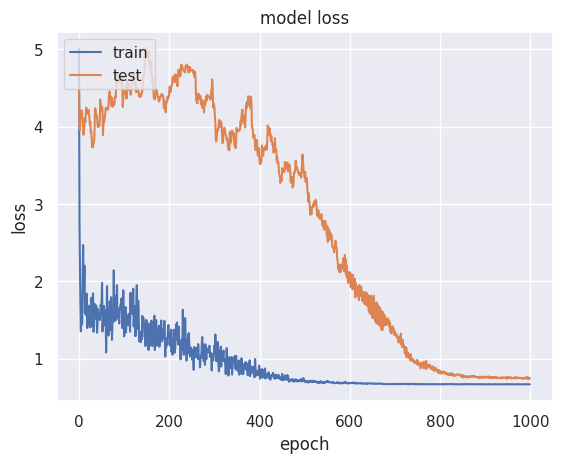

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Show top 10 destinations recommendations to a user

In [20]:
# call the places but places with drop attributes need to be downloaded(extracted..?) --> call "places" instead of movie_df
# movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.User_Id.sample(1).iloc[0]
places_visited_by_user = df[df.User_Id == user_id]
places_not_visited = places[
    ~places["Place_Id"].isin(places_visited_by_user.Place_Id.values)
]["Place_Id"]
places_not_visited = list(
    set(places_not_visited).intersection(set(place2place_encoded.keys()))
)
places_not_visited = [[place2place_encoded.get(x)] for x in places_not_visited]
user_encoder = user2user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(places_not_visited), places_not_visited)
)
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded2place.get(places_not_visited[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Places with high ratings from user")
print("----" * 8)
top_places_user = (
    places_visited_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .Place_Id.values
)
place_df_rows = places[places["Place_Id"].isin(top_places_user)]
for row in place_df_rows.itertuples():
    print(row.Place_Name, ":", row.Category)

print("----" * 8)
print("Top 10 places recommendations")
print("----" * 8)
recommended_places = places[places["Place_Id"].isin(recommended_place_ids)]
for row in recommended_places.itertuples():
    print(row.Place_Name, ":", row.Category)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Showing recommendations for user: 84
Places with high ratings from user
--------------------------------
Kampung Cina : Budaya
Pantai Ngrenehan : Bahari
Wot Batu : Cagar Alam
Observatorium Bosscha : Cagar Alam
Lawang Sewu : Budaya
--------------------------------
Top 10 places recommendations
--------------------------------
Atlantis Water Adventure : Taman Hiburan
Bukit Bintang Yogyakarta : Taman Hiburan
The World Landmarks - Merapi Park Yogyakarta : Taman Hiburan
Alun-alun Utara Keraton Yogyakarta : Budaya
Air Terjun Kedung Pedut : Cagar Alam
Desa Wisata Gamplong : Taman Hiburan
Masjid Agung Trans Studio Bandung : Tempat Ibadah
Obyek Wisata Goa Kreo : Cagar Alam
Taman Pelangi : Taman Hiburan
Keraton Surabaya : Budaya


In [21]:
model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │        15,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │        21,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ ?                      │           437 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,763 (440.48 KB)

 Trainable params: 37,587 (146.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 75,176 (293.66 KB)

In [22]:
# Save the model architecture to a h5 file
# saved_model_path_h5 = "destinatik_model_v2.h5"
model.save("destinatik_model_v2.h5")

In [23]:
# Convert to TFJS
!tensorflowjs_converter --input_format=keras destinatik_model_v2.h5 ./export/

2024-06-17 00:37:39.969436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file
